# Implementación de recocido simulado para optimización de orden de picking en almacen
---

En este problema el objetivo es determinar el orden óptimo de picking para una serie de productos en el almacén. Esto se determina mediante un algoritmo de recocido simulado cuyos parámetros e implementación se explicarán a continuación.

## Análisis del algoritmo

El algoritmo de recocido simulado tiene varios parámetros que afectan los resultados. A continuación hablaremos brevemente de los mismos.

- Perfil de decrecimiento de temperatura

Como perfil de decrecimiento se eligió, por simplicidad y para evitar el tuning de otro hiperparámetro, una función lineal en la que la temperatura disminuye un grado por cada iteración.

- Temperatura inicial

Se evaluaron distintas temperaturas iniciales y se hizo un análisis en el que se evalúa cuán mejor es la solución final que otorga el algoritmo en comparación a la solución inicial. Dicho análisis se explica más adelante pero la conclusión es que no existe una gran mejora en la calidad de la solución con temperaturas iniciales mayores a 200.

- Energía

Como función de energía para obtener la calidad de la solución para cada estado se utiliza el algoritmo A* ya implementado en el problema anterior. Para cada secuencia de coordenadas que visitar, se calcula la longitud del camino óptimo para ir de una coordenada a la siguiente dentro de la secuencia. El valor de la energía del estado será la suma de las distancias recorridas para ir de una coordenada a la otra, comenzando y finalizando en [0, 0].

- Generación de vecinos

Un estado en el algoritmo es una lista con una secuencia de coordenadas que visitar. Para generar vecinos se seleccionan las posiciones de dos elementos aleatorios dentro de la lista de coordenadas y se intercambian. Luego se calcula la energía del estado vecino y este se acepta siempre que tenga menor costo y cuando tenga mayor costo se acepta con probabilidad exp(-delta/T).

## Modelado del problema

El input del programa es una lista de productos que hay que ir a buscar y como salida se obtiene el orden óptimo del picking para minimizar la distancia recorrida. Antes de la ejecución en sí del temple, se realiza una abstracción en la que se convierte de número de producto (o posición en el almacén) a la coordenada cartesiana a la que hay que ir. Esto se hace para poder reutilizar el algoritmo ya usado del A* y para, además, poder usar a futuro este mismo código para el algoritmo genético.

Luego, a cada orden se le agregan dos coordenadas indicando que debe partir y volver a un punto determinado del almacén el cual es, en nuestro caso, [0, 0]. Así, por ejemplo, para ir a buscar los productos 8, 6, 2, 14, 30 y 17 obtendremos algo así:

In [10]:
from simulated_annealing import map_to_coord, distance, temple_simulado, neighbours_annealing

La secuencia de coordenadas, con su respectiva energía, antes de la ejecución del algoritmo es: 

In [11]:
pos_pick = [8, 6, 2, 14, 30, 17]
coordenadas = map_to_coord(pos_pick)
print("Estado inicial: ", coordenadas)
print("Energía: ", distance(coordenadas)) # Energía del estado inicial

Estado inicial:  [[0, 0], [6, 0], [4, 0], [2, 0], [9, 0], [9, 3], [1, 6], [0, 0]]
Energía:  40


Y luego de la ejecución, la secuencia de coordenas con su respectiva energía es:

In [12]:
T0 = 200
best_path = temple_simulado(coordenadas, T0, neighbours_annealing, distance)

print("Estado final: ", best_path[0])
print("Energía: ", best_path[1]) # Energía del estado inicial

Estado final:  [[0, 0], [2, 0], [4, 0], [6, 0], [9, 0], [9, 3], [1, 6], [0, 0]]
Energía:  32


Primero se genera la secuencia de coordenadas a las que hay que ir para buscar los productos tal como se dieron en la orden y el costo (en pasos) de busar los productos en dicha secuencia. Al finalizar la ejecución del algoritmo se devuelve la secuencia de coordenadas "óptimas" a las que hay que ir junto con el costo del nuevo camino. 

La solución obtenida en el algoritmo no es la final que se obtendría con el algoritmo vanilla sino la solución con mejor costo de todos los estados generados. Como nuestro objetivo es optimizar el picking, lo único que nos interesa es obtener el mejor resultado y no el último obtenido. 

Para calcular el costo de la secuencia se utiliza el algoritmo A* para obtener el camino óptimo al pasar de la primera coordenada de la secuencia a la segunda, de la segunda a la tercera y así sucesivamente. En cada ejecución del A* se suma la distancia recorrida al ir de una coordenada a la otra y la suma total será el costo de la secuencia dada. Como vemos en el ejemplo dado, el costo del camino disminuyó de 40 a 32 pasos. 

## Análisis de duración de la ejecución vs cantidad de productos en una orden para temperatura inicial constante

En este análisis se ve la complejidad temporal del algoritmo en función de la cantidad de productos que tenga una orden para temperatura inicial constante. Así es que se calcula el tiempo de ejecución del algoritmo para órdenes con 3, 5, 7, 10, 13, 15, 20, 25 y 30 productos. Para eliminar las variaciones debido a la aleatoriedad en la generación de las órdenes, se toma, para cada tamaño de orden (3, 5, 7, etc.) el tiempo promedio de ejecución luego de 50 iteraciones. Esto es, se hace un promedio de tiempo con 50 ejecuciones para cada tamaño de orden. 

In [13]:
from time import time
from random import randint

In [16]:
ITER = 50
T0 = 200

# Cantidad de productos en una orden
inputs = [3, 5, 10, 15, 20, 25, 30]

time_exec = []

for i in inputs:
    time_avg = 0
    pos_pick = []

    for j in range(0, ITER):
        pos_pick = [randint(0, 31) for i in range(0, i)]

        coordenadas = map_to_coord(pos_pick)

        start = time()
        _ = temple_simulado(coordenadas, T0, neighbours_annealing, distance)
        end = time()

        time_avg += end - start

    time_avg = time_avg/ITER
    time_exec.append(time_avg)

Se obtiene, como es de esperarse, un perfil lineal. Duplicar la cantidad de productos en la orden implica duplicar el tiempo de ejecución.

In [17]:
from matplotlib import pyplot as plt

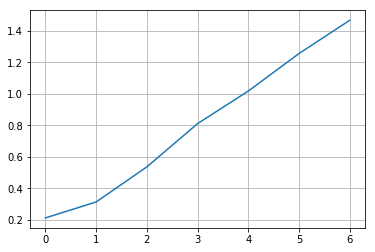

In [23]:
plt.plot(time_exec)
plt.grid()

## Análisis de temperatura inicial (cantidad de iteraciones) vs mejora en la solución

Luego, se hizo el análisis de mejora en la solución en función de la temperatura inicial. En este análisis se quiere ver qué tanto mejora porcentualmente la solución final del algoritmo respecto a la secuencia de productos inicial (generada aleatoriamente). Se calculó la mejora para temperaturas iniciales de [10, 25, 50, 100, 150, 200, 250, 300, 400, 500] para un tamaño de orden constante de 15 productos. Para eliminar las variaciones debido a la generación aleatoria de las órdenes se ejecuta 50 veces el temple simulado con cada temperatura inicial. Luego se saca el promedio de las mejoras para cada set de 50 ejecuciones de cada temperatura inicial. 

In [25]:
ITER = 50
N = 15

t0 = [10, 25, 50, 100, 150, 200, 250, 300, 400, 500]

improvement = []
time_exec = []

for temp in t0:
    
    improvement_avg = 0
    time_avg = 0

    for i in range(0, ITER):
        
        pos_pick = [randint(0, 31) for i in range(0, N)]

        coordenadas = map_to_coord(pos_pick)

        energy_start = distance(coordenadas)

        start = time()
        _, energy_end = temple_simulado(coordenadas, temp, neighbours_annealing, distance)
        end = time()

        time_avg += end - start
        improvement_avg += (energy_start - energy_end)/energy_start

    improvement_avg = improvement_avg/ITER
    improvement.append(improvement_avg)

    time_avg = time_avg/ITER
    time_exec.append(time_avg)

En el gráfico se observa, en abscisas, las temperaturas iniciales, las cuales son equivalentes a las iteraciones del algoritmo debido al perfil lineal del decrecimiento de la temperatura. En ordenadas se obtiene la mejora porcentual **promedio** del costo final de la solución respecto al costo de la orden generada aleatoriamente.

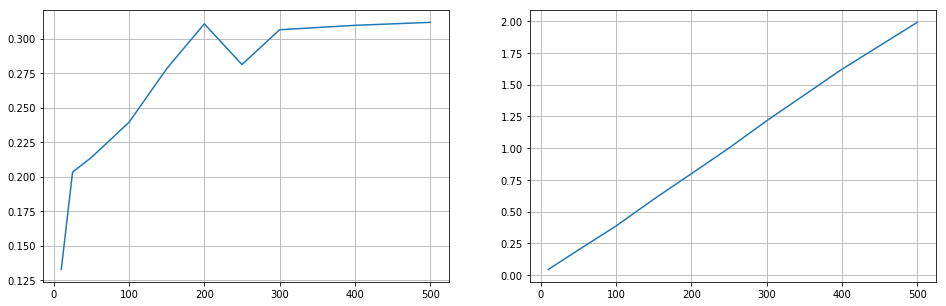

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5))
ax0.plot(t0, improvement)
ax0.grid()
ax1.plot(t0, time_exec)
ax1.grid()

mejora = (energia(inicial) - energia(final))/energia(inicial)

Este número indica cuánto mejoró la solución final, en promedio, respecto a la inicial en función de la temperatura inicial. Se puede observar que a partir de una t0 de 200 se obtienen resultados suficientemente aceptables. Duplicar la temperatura inicial significa duplicar el tiempo de ejecución pero esto no se ve reflejado en una mejora considerable en la calidad de la solución. Con 200 iteraciones ya podemos considerar que la solución provista es buena.